In [1]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib
from natsort import natsorted
from scipy.sparse.linalg import svds

In [2]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [3]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))
R = []
D = []

for i in range(10,len(g4iso_files)-1,5): # 100 keV to 1 MeV energy range in steps of 100 keV
    R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0)
    #print(g4iso_files[i])
R = np.transpose(np.array(R))
RR = R
for j in range(0,470): # X-ray spectra from 0 to 600 keV
    if (np.linalg.norm(R[j,:] > 0)):
        D.append((1.0/np.linalg.norm(R[j,:]))) # Diagonal scaling as a left pre-conditioner
    else:
        D.append(1)

DD = np.diag(D)
RT = np.matmul(DD,R)

S = []
for k in range(0,R.shape[1]):
    #S.append(1.0/(k+1)**2) # right pre-conditioner towards an exponential
    S.append(1.0/np.sum(R[:,k]))
    #S.append(alexa_model_exp[k])
    #S.append(1)
SS = np.diag(S)
RS = np.matmul(RT,SS)

print('response condition number: ' + str(np.linalg.cond(R)))
print('response condition number after preconditioning: ' + str(np.linalg.cond(RS)))

elow_keV = 110
ehigh_keV = 1960
xspace_estep_keV = 1
espace_estep_keV = 50

espace = np.linspace(elow_keV,ehigh_keV,R.shape[1])
xspace = np.linspace(30,500,R.shape[0])




response condition number: 15993.388434455901
response condition number after preconditioning: 173.12830996456856


In [4]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))

def cnum(xbinw,ebinw,num_components):
    R = []
    D = []

    for i in range(5,len(g4iso_files),ebinw): # 100 keV to 1 MeV energy range in steps of 100 keV
        R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:2000:xbinw,3]/5000000.0)
    R = np.transpose(np.array(R))
    u, s, v = svds(R, k=min(R.shape)-num_components)
    R = u.dot(np.diag(s))  # output of TruncatedSVD
    
    return(np.linalg.cond(R))

In [5]:
def tsvd(num_components):

    X = np.arange(10, 100, 5)
    Y = np.arange(1, 20, 1)
    XX, YY = np.meshgrid(X, Y)
    Z = []
    zm=[]
    for i in X:
        print(i)
        for j in Y:
            zm.append(cnum(i,j,num_components))
        Z.append(zm)
        zm=[]
    ZZ = np.transpose(np.array(Z))
    return([XX,YY,ZZ])

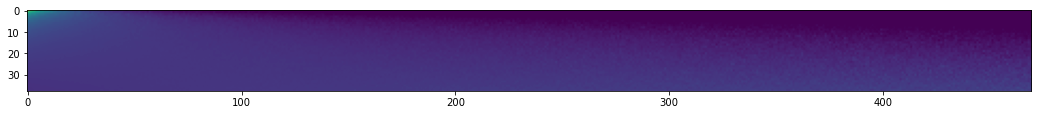

In [6]:

from matplotlib import ticker, cm

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(RS.T)



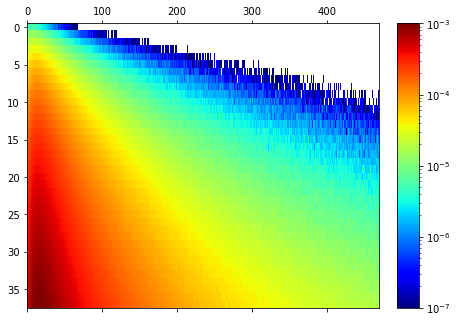

In [7]:
from matplotlib.colors import LogNorm
f = plt.figure(figsize=(10, 5))
ax = f.add_axes([0.17, 0.02, 0.92, 0.79])
axcolor = f.add_axes([0.90, 0.02, 0.03, 0.79])
im = ax.matshow(R.T, aspect=10,norm=LogNorm(vmin=1e-7, vmax=1e-3),cmap='jet')
t = np.logspace(-7,-3,5)
f.colorbar(im, cax=axcolor,ticks=t)

In [8]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))

def get_binned_matrix(xbinw,ebinw):
    R = []
    D = []

    for i in range(5,len(g4iso_files),ebinw): # 100 keV to 1 MeV energy range in steps of 100 keV
        R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:2000:xbinw,3]/5000000.0)
    R = np.transpose(np.array(R))    
    return(R)

<ipython-input-19-3daa4b676cb8>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


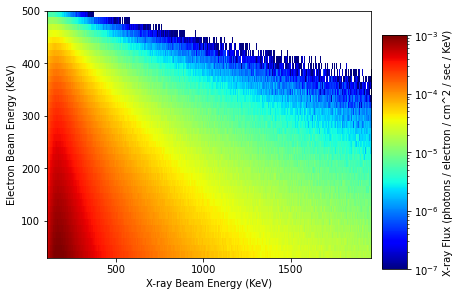

In [19]:
#font = {'family' : 'DejaVu Sans',
        #'weight' : 'normal',
        #'size'   : 19}

#matplotlib.rc('font', **font)


f = plt.figure(figsize=(5, 5))
ax = f.add_axes([0.17, 0.02, .90, 0.89])
axcolor = f.add_axes([1.1, 0.09, .07, 0.65])
im = ax.matshow(R.T,extent=[espace[0],espace[-1],xspace[0],xspace[-1]],aspect=3,norm=LogNorm(vmin=1e-7, vmax=1e-3),cmap='jet')
t = np.logspace(-7,-3,5)
ax.xaxis.set_ticks_position('bottom')
cbar = f.colorbar(im, cax=axcolor,ticks=t)
plt.tight_layout()
ax.set_xlabel('X-ray Beam Energy (KeV)')
ax.set_ylabel('Electron Beam Energy (KeV)')
cbar.ax.set_ylabel('X-ray Flux (photons / electron / cm^2 / sec / KeV)')
plt.savefig('fig.pdf')

